<font size="6">**Plant Seedlings Classification**</font><br>


In [30]:
from clearml import Task, Logger, OutputModel
import torch
from torch.utils import data as data
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import seaborn as sns
from tqdm import tqdm
from torchview import draw_graph

<font size="6">**Define GPU support**</font>

In [3]:
# Define GPU support
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 3080 Ti


<font size="6">**Setting training number for tracking with Clearml**</font>

In [4]:
train_number = 81

<font size="6">**Define Functions**</font> <br>
1. Count the number of samples of each class for the entire dataset.<br>
2. Count the number of samples of each class for batch.<br>
3. Show some random images from data loader.<br>
4. Calculate mean and std of dataset.<br>
5. Validation function for the training process.

In [4]:
def count_labels(loader, classes, title):
    """count the number of samples of each class for the entire dataset and print a distribution chart.

    Parameters
    ----------
    loader : pytorch dataloader
        The dataloader we want to count.
    classes : list
        A list of the classes names.
    title : string
        The title of the chart.

    Returns
    -------
    None
    """
    labels = []
    for label in tqdm(loader.dataset):
        labels.append(classes[label[1]])
    
    train_Y = pd.DataFrame(labels)
    train_Y.rename(columns={0:'species'},inplace=True)
    plt.figure(figsize=(12,5))
    chart = sns.countplot(data=train_Y, x='species')
    n = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, ha='right')
    plt.title(title)

def count_labels_batch(loader, classes, batch_num, title, start=False):
    """count the number of samples of each class for batch and print a distribution chart.

    Parameters
    ----------
    loader : pytorch dataloader
        The dataloader we want to count.
    classes : list
        A list of the classes names.
    batch_num : int
        Batch num to print.
    title : string
        The title of the chart and define the loader batch list name.
    start : boolean
        True - starts the counting (for first time).
        False - doesn't count (just printing the chart for the asked batch).

    Returns
    -------
    None
    """
    name = title + '_arr_batch'
    if start:
        globals()[name] = []
        for i, (_ , labell) in enumerate(tqdm(loader, desc='iteration')):
            labell = [classes[i] for i in labell]
            globals()[name].append(labell)
    
    batch = pd.DataFrame(globals()[name][batch_num])
    batch.rename(columns={0:'species'},inplace=True)
    plt.figure(figsize=(12,5))
    chart = sns.countplot(data=batch, x='species')
    n = chart.set_xticklabels(chart.get_xticklabels(), rotation=45, ha='right')
    plt.title(f'{title} Batch Distribution')

def show_random_imgs(data_loader, classes, amount, norm = False):
    """Show some random images from data loader.

    Parameters
    ----------
    data_loader : pytorch dataloader
        The dataloader we want to count.
    classes : list
        A list of the classes names.
    amount : int
        The amount of images to show.
    norm : boolean
        True - data normalized.
        False - data didn't normalized.

    Returns
    -------
    None
    """
    images, labels = next(iter(data_loader))

    if norm == True:
        mean = [0.3290, 0.2895, 0.2071]
        std = [0.1041, 0.1096, 0.1267]
    else:
        mean= [0,0,0]
        std = [1,1,1]

    rows = int(math.sqrt(amount))
    columns = math.ceil(amount/rows)

    plt.figure()
    for i in range(amount):
        fig = plt.subplot(rows,columns,i+1)
        images[i][0] = images[i][0]*std[0] + mean[0]
        images[i][1] = images[i][1]*std[1] + mean[1]
        images[i][2] = images[i][2]*std[2] + mean[2]
        plt.imshow(np.transpose(images[i].to('cpu').numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'GT: {classes[labels[i].item()]}')
        
    plt.subplots_adjust(right=1 + 2*float(f'0.{columns}'), top=1 + 2*float(f'0.{rows}'))

def get_mean_and_std(dataloader):
    """calculate mean and std of dataset.

    Parameters
    ----------
    dataloader : pytorch dataloader
        The dataloader we want to count.

    Returns
    -------
    mean : list
        The mean values for each channel.
    std : list
        The standard deviation values for each channel.
    """
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for img, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(img, dim=[0,2,3])
        channels_squared_sum += torch.mean(img**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

def validate(model, loss_func, val_loader):
    """Validation function for the training process.

    Parameters
    ----------
    model : pytorch nn.Module
        The deep learning model.
    loss_func : pytorch loss function
        The model loss function.
    val_loader : pytorch dataloader
        The validation dataloader.

    Returns
    -------
    val_loss : float
        The validation loss.
    val_accuracy : float
        The validation accuracy.
    """
    val_loss = 0
    equality = 0
    val_accuracy = 0
    for i, (images,labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.to(device)

        val_output = model(images)
        val_loss += loss_func(val_output, labels).item()
         
        equality = (torch.argmax(val_output, dim=1) == labels)
        val_accuracy += equality.type(torch.FloatTensor).mean()
    
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)

    return val_loss, val_accuracy

<font size="6">**Loading the dataset**</font><br>
1. Define paths to train and test folders.<br>
2. Define preprocessing transformers.<br>
3. Defining Augmentation.<br>
3. Loading the data from folders.<br>
4. Split the dataset to training and validation - 80% training and 20% validation.

In [5]:
# Loading the dataset
train_per = 0.8
val_per = 0.2
n_classes = 12
image_size = 256
train_path = os.path.join('data', 'train')
test_path = os.path.join('data', 'test')
classes = os.listdir(train_path)

# preprocessing
train_transforms = transforms.Compose(
    [
        transforms.Resize([image_size,image_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

train_aug_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.RandomPerspective(distortion_scale= 0.5, p= 0.3),
        transforms.Resize([image_size,image_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize([image_size,image_size]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

# load the data
dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
dataset_aug = datasets.ImageFolder(root=train_path, transform=train_aug_transforms)
dataset_combine = torch.utils.data.ConcatDataset([dataset, dataset_aug])
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

# split the data to training and validation
train_data_len = int(len(dataset_combine) * train_per)
val_data_len = int(len(dataset_combine) * val_per)
train_dataset, val_dataset = data.random_split(dataset_combine, [train_data_len, val_data_len], generator=torch.Generator().manual_seed(42))

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

Train samples: 7600, Validation samples: 1900, Test samples: 794


<font size="6">**Encapsulate the data into dataloader form**</font><br>
Batch size is 256.<br>
Shows some random training images.

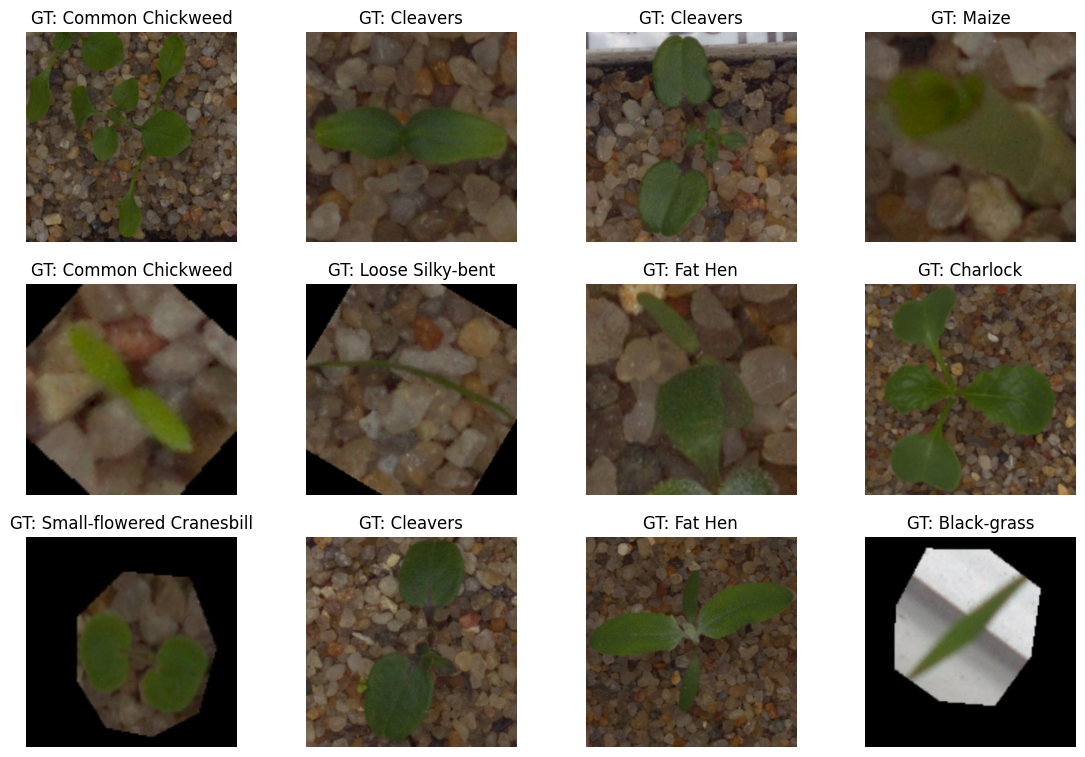

In [6]:
# encapsulate data into dataloader form
batch_size = 256

train_loader = data.DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size, shuffle=True)

# show some random training images
show_random_imgs(train_loader, classes, 12, True) 

<font size="6">**Count the number of samples of each class for the entire dataset**</font><br>

100%|██████████| 7600/7600 [00:55<00:00, 136.85it/s]


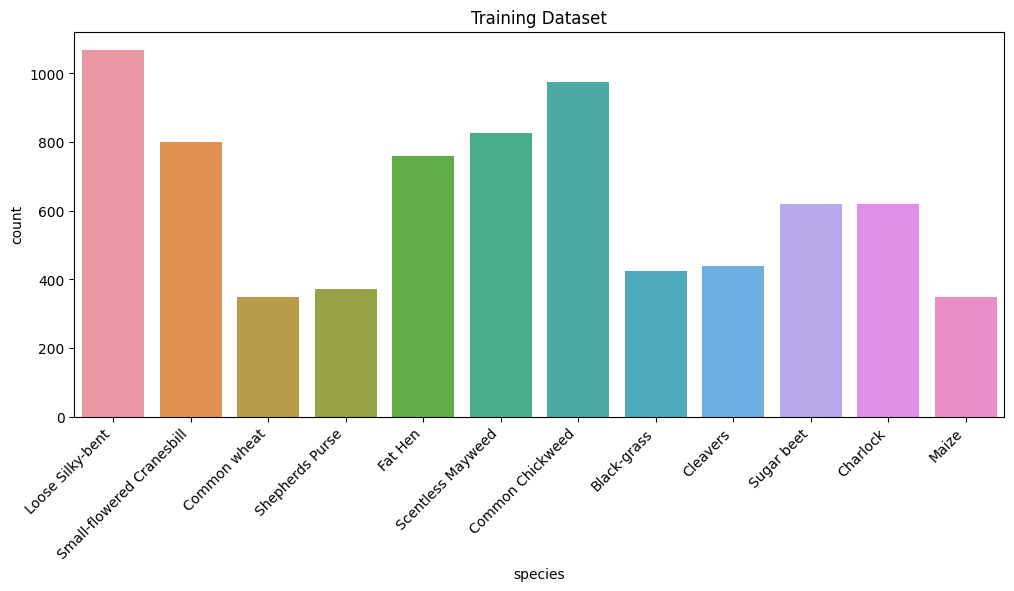

In [14]:
# count the number of samples in each class for all dataset
count_labels(train_loader, classes, 'Training Dataset')

<font size="6">**Count the number of samples of each class for a batch**</font><br>

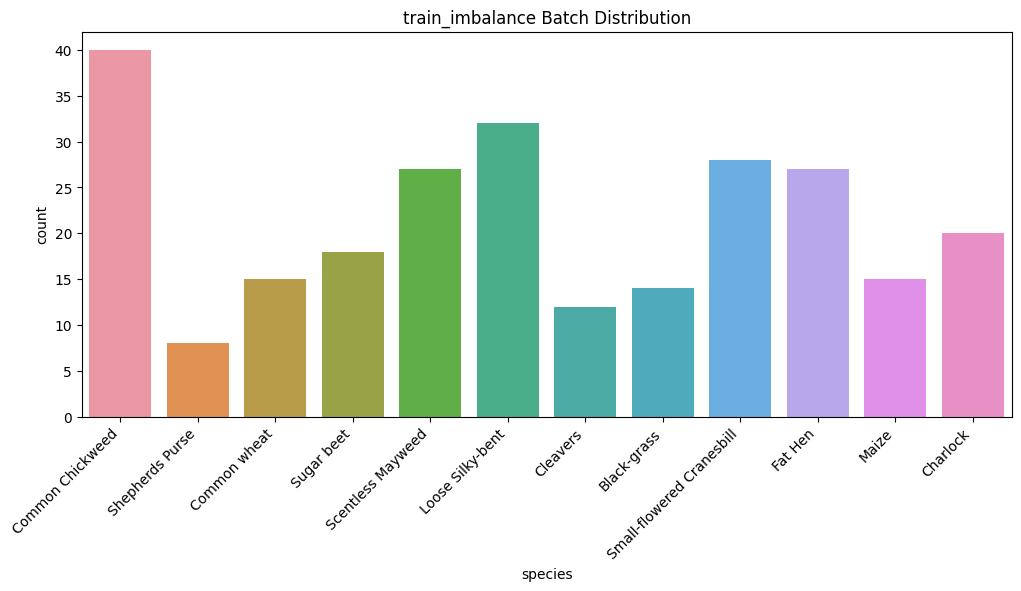

In [19]:
# count the number of samples in each class for batch
count_labels_batch(train_loader, classes, 4, 'train_imbalance', False)

<font size="6">**Address class imbalance using Weighted Random Sampler**</font><br>

In [7]:
# Address class imbalance using Weighted Random Sampler
labels = [label[1] for label in train_loader.dataset]
labels_unique, counts = np.unique(labels, return_counts=True)
class_weights = [counts.sum() / c for c in counts]
example_weights = [class_weights[e] for e in labels]
sampler = data.WeightedRandomSampler(example_weights, len(labels))
train_loader = data.DataLoader(train_dataset, batch_size, sampler=sampler)

<font size="6">**Count the number of samples of each class for a batch after balance tha data**</font><br>

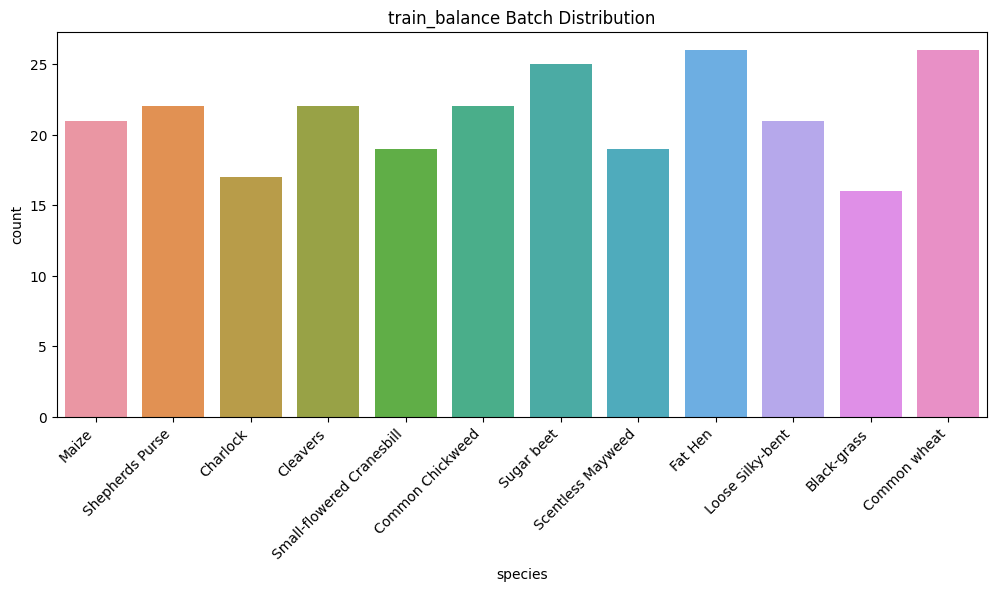

In [29]:
# count the number of samples in each class for batch
count_labels_batch(train_loader, classes, 3, 'train_balance', False)

<font size="6">**Building the CNN model**</font><br>

In [18]:
# Building the CNN model
class SeedClassifier(nn.Module):
    def __init__(self) -> None:
        super(SeedClassifier, self).__init__()
        self.Conv1 = nn.Conv2d(3,32,3, padding=1, bias=False)
        self.BN1 = nn.BatchNorm2d(32)
        self.RelU1 = nn.ReLU()
        self.Maxpool1 = nn.MaxPool2d(2)

        self.Conv2 = nn.Conv2d(32,64,3, stride=2, bias=False)
        self.BN2 = nn.BatchNorm2d(64)
        self.RelU2 = nn.ReLU()
        self.Maxpool2 = nn.MaxPool2d(2)

        self.Conv3 = nn.Conv2d(64,128,3, stride=2, bias=False)
        self.BN3 = nn.BatchNorm2d(128)
        self.RelU3 = nn.ReLU()
        self.Maxpool3 = nn.MaxPool2d(2)

        self.Conv4 = nn.Conv2d(128,256,3, bias=False)
        self.BN4 = nn.BatchNorm2d(256)
        self.RelU4 = nn.ReLU()

        self.Fc1 = nn.Linear(256*5*5,2048, bias=False)
        self.BN5 = nn.BatchNorm1d(2048)
        self.RelU6 = nn.ReLU()
        self.Dropout1 = nn.Dropout1d(0.1)

        self.Fc2 = nn.Linear(2048,512, bias=False)
        self.BN6 = nn.BatchNorm1d(512)
        self.RelU7 = nn.ReLU()
        self.Dropout2 = nn.Dropout1d(0.1)

        self.Fc3 = nn.Linear(512,12 , bias=False)
        self.Dropout3 = nn.Dropout1d(0.01)

    def forward(self, x):
        x = self.Conv1(x)
        x = self.BN1(x)
        x = self.RelU1(x)
        x=self.Maxpool1(x)
        x=self.Conv2(x)
        x = self.BN2(x)
        x = self.RelU2(x)
        x=self.Maxpool2(x)
        x=self.Conv3(x)
        x = self.BN3(x)
        x = self.RelU3(x)
        x=self.Maxpool3(x)
        x=self.Conv4(x)
        x = self.BN4(x)
        x = self.RelU4(x)
        x = x.view(-1, 256*5*5)
        x = self.Fc1(x)
        x = self.BN5(x)
        x = self.RelU6(x)
        x = self.Dropout1(x)
        x = self.Fc2(x)
        x = self.BN6(x)
        x = self.RelU7(x)
        x = self.Dropout2(x)
        x = self.Fc3(x)
        x = self.Dropout3(x)

        return x
    
seed_classifier = SeedClassifier().to(device)
summary(seed_classifier,(3,image_size,image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 63, 63]          18,432
       BatchNorm2d-6           [-1, 64, 63, 63]             128
              ReLU-7           [-1, 64, 63, 63]               0
         MaxPool2d-8           [-1, 64, 31, 31]               0
            Conv2d-9          [-1, 128, 15, 15]          73,728
      BatchNorm2d-10          [-1, 128, 15, 15]             256
             ReLU-11          [-1, 128, 15, 15]               0
        MaxPool2d-12            [-1, 128, 7, 7]               0
           Conv2d-13            [-1, 256, 5, 5]         294,912
      BatchNorm2d-14            [-1, 25

<font size="6">**Visualizing the CNN model**</font><br>


(process:16100): Pango-WARNING **: 14:04:17.541: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


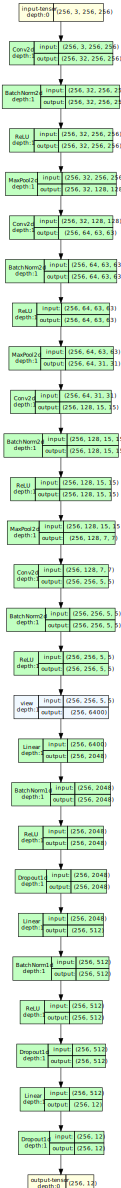

In [33]:
model_graph = draw_graph(seed_classifier, input_size=(batch_size, 3, image_size, image_size), device='meta')
model_graph.visual_graph

<font size="6">**Using Transfer Learning with Efficientnet B0**</font><br>
Adding Dropout, SilU Linear layers to the classifier to match our number of classes.

In [36]:
# Using efficientnet B0
seed_classifier = torchvision.models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')

# disable model weights updating
# for param in seed_classifier.parameters():
#     param.requires_grad = False

seed_classifier.classifier[0] = nn.Dropout1d(p=0.1, inplace=True)
seed_classifier.classifier.append(nn.SiLU(inplace=True))
seed_classifier.classifier.append(nn.Linear(in_features=1000, out_features=12))
seed_classifier.classifier.append(nn.Dropout1d(p=0.1, inplace=True))
seed_classifier.to(device)

# for name, param in seed_classifier.named_parameters():
#     #if param.requires_grad:
#     print(name, param.requires_grad)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

<font size="6">**Visualizing the Efficientnet B0 model**</font><br>


(process:14428): Pango-WARNING **: 14:06:47.590: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


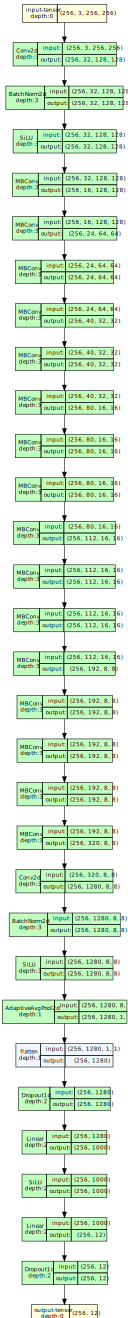

In [37]:
model_graph = draw_graph(seed_classifier, input_size=(batch_size, 3, image_size, image_size), device='meta')
model_graph.visual_graph

<font size="6">**Loading the dataset fot the Efficientnet B0**</font><br>
1. Define paths to train and test folders.<br>
2. Define preprocessing transformers.<br>
3. Defining Augmentation.<br>
3. Loading the data from folders.<br>
4. Split the dataset to training and validation - 80% training and 20% validation.<br>
6. Encapsulate the data into dataloader form.<br>
7. Batch size is 128.<br>

In [39]:
# Loading the dataset
train_per = 0.8
val_per = 0.2
n_classes = 12
image_size = 256
train_path = os.path.join('data', 'train')
test_path = os.path.join('data','test')
classes = os.listdir(train_path)

# preprocessing
train_transforms = transforms.Compose(
    [
        transforms.Resize([image_size,image_size]),#, interpolation='InterpolationMode.BICUBIC'),
        transforms.CenterCrop([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

train_aug_transforms = transforms.Compose(
    [
        transforms.Resize([image_size,image_size]),#, interpolation='InterpolationMode.BICUBIC'),
        transforms.CenterCrop([224,224]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.25),
        transforms.RandomRotation(degrees=(0, 180)),
        transforms.RandomPerspective(distortion_scale= 0.5, p= 0.3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize([image_size,image_size]),#, interpolation='InterpolationMode.BICUBIC'),
        transforms.CenterCrop([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3290, 0.2895, 0.2071], std=[0.1041, 0.1096, 0.1267])
    ]
)

# load the data
dataset = datasets.ImageFolder(root=train_path, transform=train_transforms) # no aug
dataset_aug = datasets.ImageFolder(root=train_path, transform=train_aug_transforms)
dataset_combine = torch.utils.data.ConcatDataset([dataset, dataset_aug])
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)

# split the data to training and validation
train_data_len = int(len(dataset_combine) * train_per)
val_data_len = int(len(dataset_combine) * val_per)
train_dataset, val_dataset = data.random_split(dataset_combine, [train_data_len, val_data_len], generator=torch.Generator().manual_seed(42))

print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

# encapsulate data into dataloader form
batch_size = 128

train_loader = data.DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size, shuffle=True)


Train samples: 7600, Validation samples: 1900, Test samples: 794


<font size="6">**Performing the training process.**</font><br>
1. Loss Function: CrossEntropyLoss.<br>
2. Optimizer: Adam.<br>
3. Initial Learning Rate: 0.001 and drops twice by 10.<br>
4. Number of epochs: 70.

In [9]:
# Add ClearML task
train_number += 1
task = Task.init(project_name="Seed_Classifier", task_name=f"CNN training {train_number}")

# train the CNN model
learning_rate = 0.0001
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(seed_classifier.parameters(), lr=learning_rate)
epochs = 70
drop_lr = [30, 50]
j = 0
n_total_steps = len(train_loader)
val_every = math.ceil(n_total_steps/60)
train_loss= []
train_acc = 0
train_acc_list = []
val_loss_list = []
val_acc_list = []
iterations = 0
seed_classifier.train()

# update hyper parameters to ClearML
params = {
    "number_of_epochs": epochs,
    "batch_size": batch_size,
    "base_lr": learning_rate,
    "loss_func": "CrossEntropyLoss",
    "optimizer": optimizer.__module__,
    "Augmentation": "True",
    "Normalization": "True - of the original",
    "Image_Size": image_size,
    "Drop lr": f"after {drop_lr} epochs",
    "model": "Ours"
}
params = task.connect(params)

# upload model architecture to ClearML
output_model = OutputModel(task=task)
output_model.update_design(config_dict=seed_classifier.__dict__['_modules'])

# starting the training loop
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = seed_classifier(images)
        loss = loss_func(output, labels)
        
        # calculate training accuracy
        with torch.no_grad():
            equality = (torch.argmax(output, dim=1) == labels)
            train_acc += equality.type(torch.FloatTensor).mean()
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % val_every == 0:
            seed_classifier.eval()

            # updating training loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "training loss", iteration=iterations, value=loss.item())
            Logger.current_logger().report_scalar("Accuracy","training accuracy", iteration=iterations, value=train_acc/iterations)

            # calculate validation loss and accuracy
            with torch.no_grad():
                val_loss, val_acc = validate(seed_classifier, loss_func, val_loader)

            # updating validation loss and accuracy to clearml server
            Logger.current_logger().report_scalar("Loss", "val loss", iteration=iterations, value=val_loss)
            Logger.current_logger().report_scalar("Accuracy","val accuracy", iteration=iterations, value=val_acc)

            train_acc_list.append(train_acc/iterations)
            train_loss.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Accuracy: {train_acc/iterations:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr = {learning_rate}')
            seed_classifier.train()

    # decreasing learning rate every drop_lr epochs
    if j < len(drop_lr):
        if (epoch+1) % drop_lr[j] == 0:
            learning_rate = learning_rate/10
            j += 1

# close ClearML task
task.close()

print('Finished Training')

ClearML Task: created new task id=ea02785bcdb347b0b709add0426fbe17
2023-02-14 10:14:31,412 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2023-02-14 10:14:31,413 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/0915fc62fce547d1bdaf0e8717f59dec/experiments/ea02785bcdb347b0b709add0426fbe17/output/log
Epoch [1/70], Step [1/30], Training Loss: 2.5608, Training Accuracy: 0.0625, Validation Loss: 2.4850, Validation Accuracy: 0.0937, lr = 0.0001
Epoch [1/70], Step [2/30], Training Loss: 2.4322, Training Accuracy: 0.1016, Validation Loss: 2.4837, Validation Accuracy: 0.1023, lr = 0.0001
Epoch [1/70], Step [3/30], Training Loss: 2.2931, Training Accuracy: 0.1458, Validation Loss: 2.4823, Validation Accuracy: 0.0980, lr = 0.0001
Epoch [1/70], Step [4/30], Training Loss: 2.1561, Training Accuracy: 0.1865, Validation Loss: 2.4784, Validation Accuracy: 0.0998, lr = 0.0001
Ep

<font size="6">**Saving the model.**</font><br>

In [10]:
# save the CNN model
path =  f'models/CNN_model_{train_number}.pth'
torch.save(seed_classifier.state_dict(), path)

In [15]:
# load model
# model_loaded = SeedClassifier().to(device=device)
# model_loaded.load_state_dict(torch.load(f'models/CNN_model_82.pth'))
# model_loaded.eval()
seed_classifier.load_state_dict(torch.load(f'models/CNN_model_70.pth'))

<All keys matched successfully>

<font size="6">**Training graphs for the CNN model.**</font><br>
94% on Validation Accuracy.

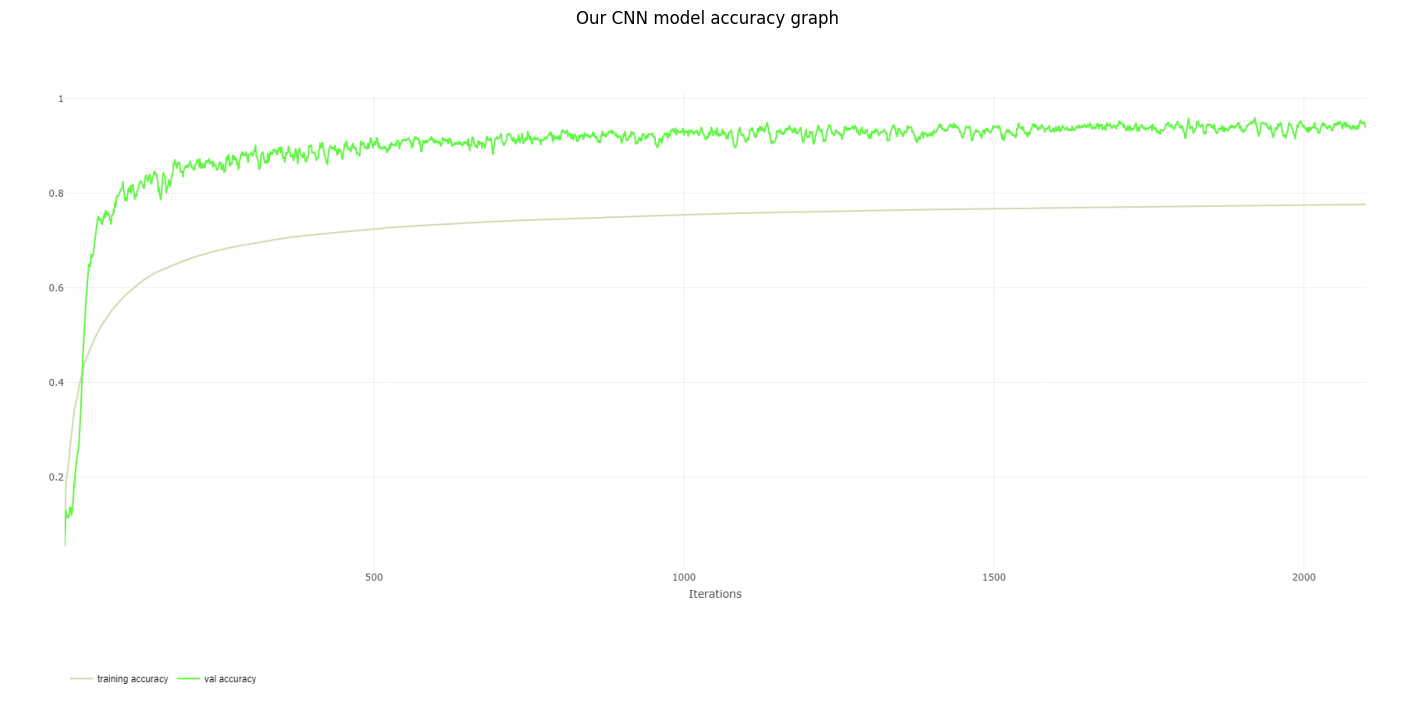

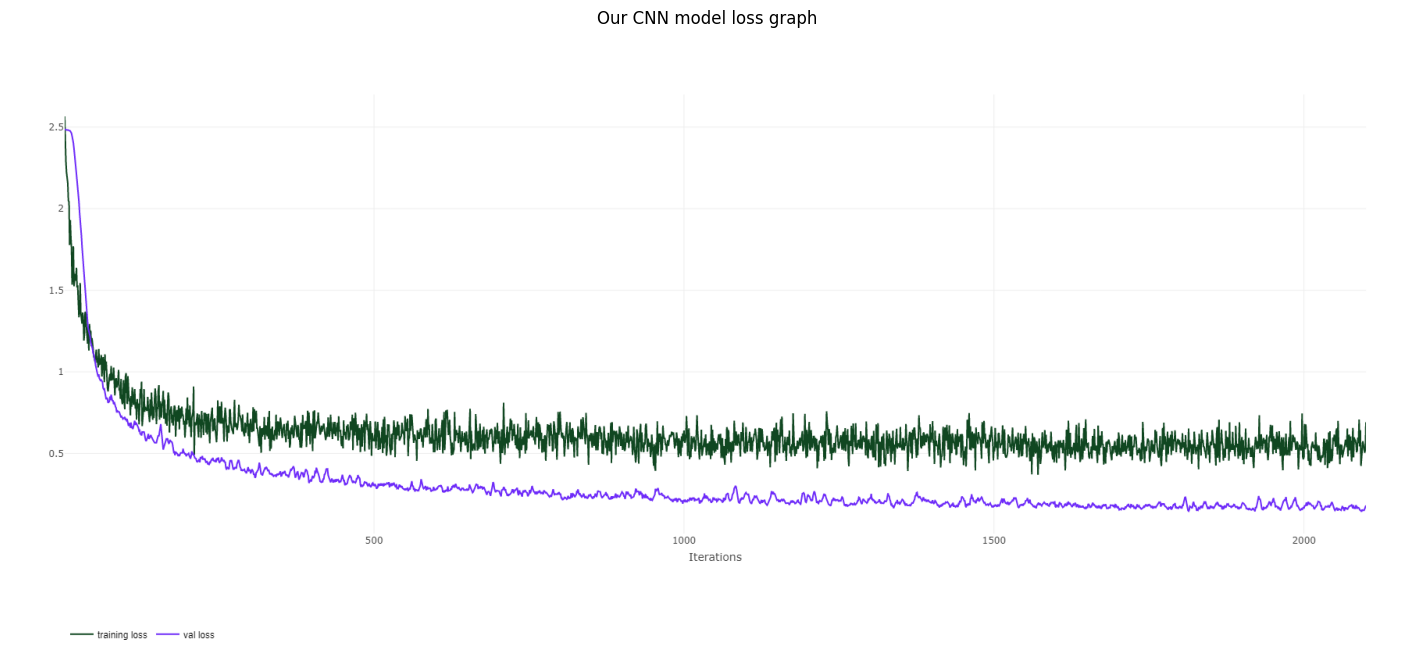

In [29]:
CNN_model_83_accuracy_graph = plt.imread('CNN_model_83_accuracy_graph.png')
CNN_model_83_loss_graph = plt.imread('CNN_model_83_loss_graph.png')

plt.figure(figsize=(18,20))
plt.imshow(CNN_model_83_accuracy_graph)
plt.title('Our CNN model accuracy graph')
plt.axis('off')

plt.figure(figsize=(18,20))
plt.imshow(CNN_model_83_loss_graph)
plt.title('Our CNN model loss graph')
f =plt.axis('off')


<font size="6">**Training graphs for Efficientnet B0 model.**</font><br>
98% on Validation Accuracy.

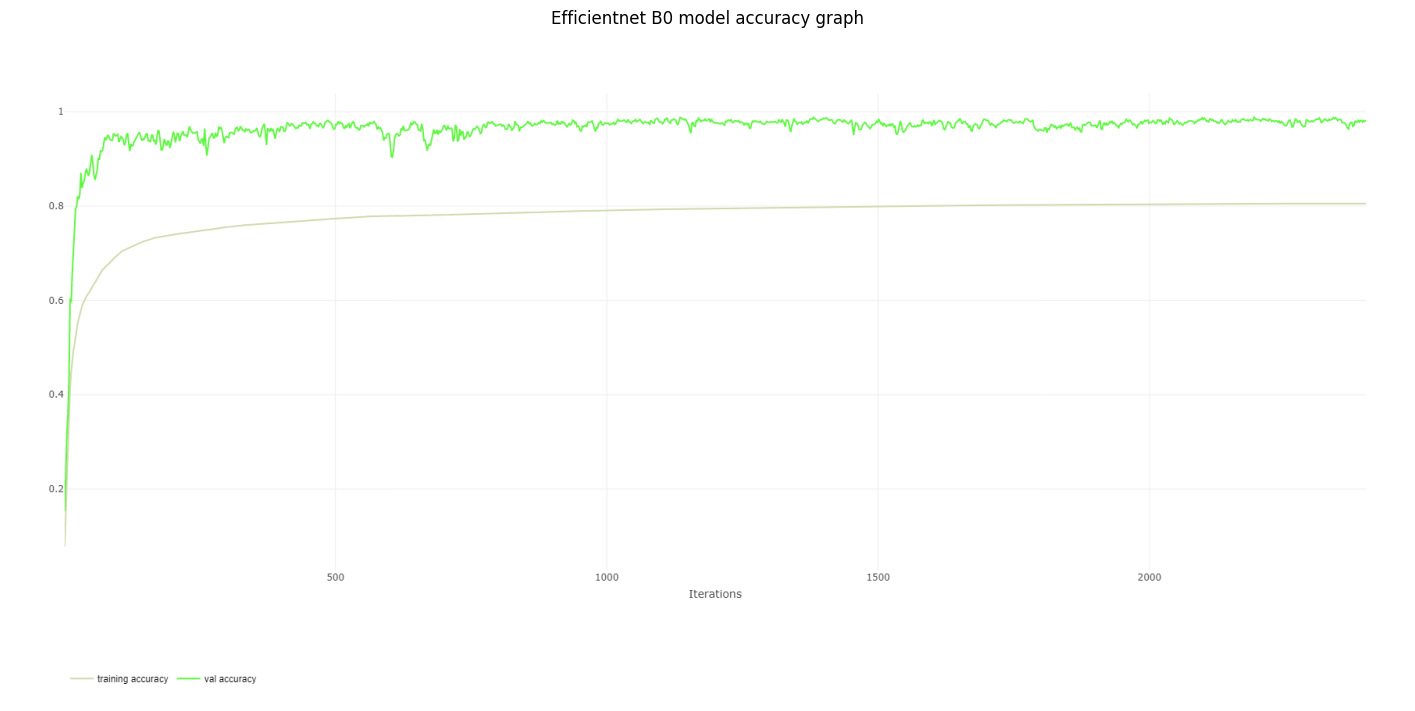

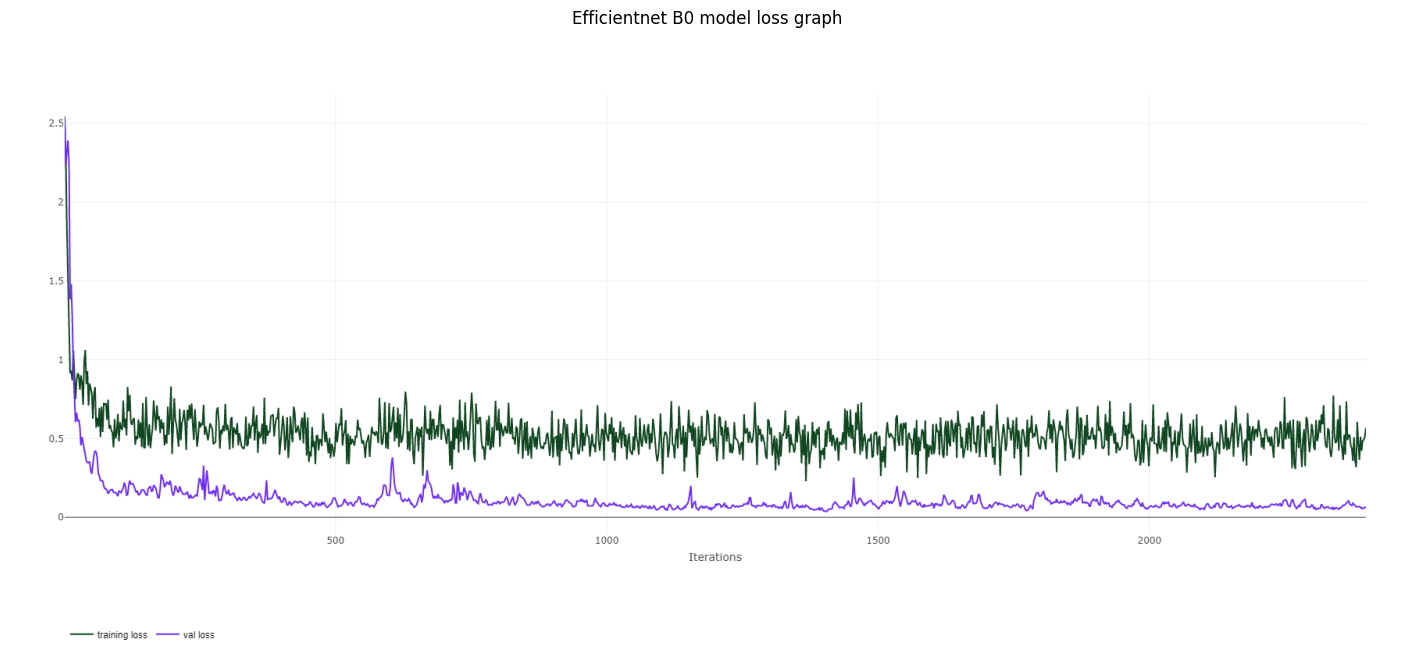

In [28]:
CNN_model_83_accuracy_graph = plt.imread('CNN_model_70(Efficientnet B0)_accuracy_graph.png')
CNN_model_83_loss_graph = plt.imread('CNN_model_70(Efficientnet B0)_loss_graph.png')

plt.figure(figsize=(18,20))
plt.imshow(CNN_model_83_accuracy_graph)
plt.title('Efficientnet B0 model accuracy graph')
plt.axis('off')

plt.figure(figsize=(18,20))
plt.imshow(CNN_model_83_loss_graph)
plt.title('Efficientnet B0 model loss graph')
f =plt.axis('off')


<font size="6">**Prediction**</font><br>
1. Predict the test dataset.<br>
2. Save the image file name and prediction to csv file.<br>
3. Show some samples.

In [ ]:
# predict test dataset
seed_classifier.eval()
prediction = []

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)

        test_output = seed_classifier(images)
        prediction.extend(torch.argmax(test_output, dim=1).to('cpu').numpy())

files_names = os.listdir(test_path + '/0')
prediction = [classes[i] for i in prediction]

# Save the image file name and prediction to csv file.
submission = pd.DataFrame()
submission['file'] = files_names
submission['species'] = prediction
submission.to_csv('submission_1.csv', index=False)

# showing examples
amount = 12
mean = [0.3290, 0.2895, 0.2071]
std = [0.1041, 0.1096, 0.1267]

rows = int(math.sqrt(amount))
columns = math.ceil(amount/rows)

plt.figure()
for i in range(amount):
    fig = plt.subplot(rows,columns,i+1)
    images[i][0] = images[i][0]*std[0] + mean[0]
    images[i][1] = images[i][1]*std[1] + mean[1]
    images[i][2] = images[i][2]*std[2] + mean[2]
    plt.imshow(np.transpose(images[i].to('cpu').numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Prediction: {classes[torch.argmax(test_output, dim=1)[i].item()]}')
    
plt.subplots_adjust(right=1 + 2*float(f'0.{columns}'), top=1 + 2*float(f'0.{rows}'))

<font size="6">**Kaggle evaluation of the test results.**</font><br>
1. The score for the Efficientnet B0 model is 97.1%
2. The score for our CNN model with balance data is 93.7%
3. The score for our CNN model with imbalance data is 92.1%

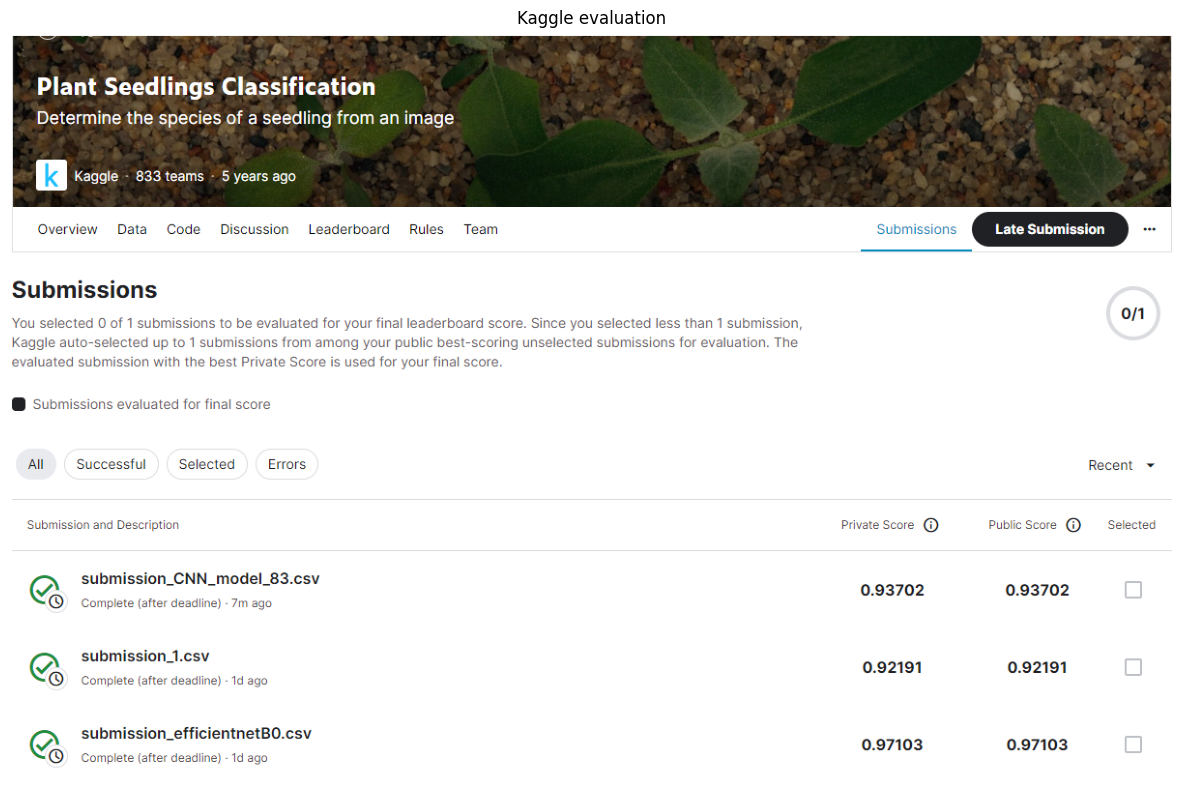

In [25]:
Kaggle_evaluation = plt.imread('Kaggle evaluation.png')

plt.figure(figsize=(15,20))
plt.imshow(Kaggle_evaluation)
plt.title('Kaggle evaluation')
f = plt.axis('off')